# Milestone #4

In this notebook we will look to fit a baseline model to the data. We first need several functions to be able to split and analyze our data. First and foremost we will need to import sklearn packages in order to implement the model. We will also need to build some functions that will allow us to analyze the efficacy of particular models.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn import cross_validation
from sklearn import metrics
from sklearn import ensemble
from sklearn import discriminant_analysis
from sklearn import svm

%matplotlib inline

In [2]:
def KFold_Score(folds, X, y, mdl, metric_func=metrics.accuracy_score):
    """
    Function to take in a single training set and check the efficacy 
    of a particular model using `folds`-fold validation.
    
    The function returns the mean of the `folds` `metric` scores
    """
    # fold the dataset into `folds`
    kf = cross_validation.KFold(len(X), n_folds=folds)
    
    # array to store results
    kf_res = np.empty((folds,))
    
    for i, (train_ix, test_ix) in enumerate(kf):
        fold_model = mdl
        fold_model.fit(X[train_ix, :], y[train_ix])
        
        # inputs are y_true, y_pred
        kf_res[i] = metric_func(y[test_ix], fold_model.predict(X[test_ix, :]))
        
    # aggregate scores by averaging 
    return np.nanmean(kf_res)

Let us load in our data.

In [3]:
FI = pd.read_csv('datasets/Food_Inspections.csv', index_col='Inspection ID')

In [4]:
FI.head()

,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
Inspection ID,,,,,,,,,,,,,,,,
1967170,"GOOSE ISLAND BAR - T1, B4",GOOSE ISLAND (T1-B4),2477070.0,Restaurant,Risk 2 (Medium),11601 W TOUHY AVE,CHICAGO,IL,60666.0,10/25/2016,License,Pass,NaN,42.008536,-87.914428,"(42.008536400868735, -87.91442843927047)"
1967164,ERMEL'S,ERMEL'S,2484238.0,Restaurant,Risk 1 (High),5729 N NORTHWEST HWY,CHICAGO,IL,60646.0,10/25/2016,License,Pass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.986001,-87.787528,"(41.98600113711187, -87.78752792018707)"
1967146,"WENDY'S PROPERTIES, LLC",WENDY'S,2469194.0,Restaurant,Risk 1 (High),6324 N WESTERN AVE,CHICAGO,IL,60659.0,10/25/2016,License,Pass,NaN,41.996677,-87.689996,"(41.99667685737697, -87.68999575516291)"
1967133,LEARN TOGETHER GROW TOGETHER CHILD DEVELOPMENT...,LEARN TOGETHER GROW TOGETHER CHILD DEVELOPMENT C,2384887.0,Daycare Above and Under 2 Years,Risk 1 (High),1126 W 99TH ST,CHICAGO,IL,60643.0,10/25/2016,License,Pass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.714241,-87.651464,"(41.714240500986136, -87.6514643961654)"
1967115,Porkchop,Porkchop,2373923.0,Restaurant,Risk 1 (High),29 E ADAMS ST,CHICAGO,IL,60603.0,10/24/2016,Short Form Complaint,Pass,NaN,41.879397,-87.626631,"(41.87939700209408, -87.62663087278814)"


### Data Cleaning

This data definitely needs to be cleaned. This will take several steps.

* Remove immediate non-predictor columns (`DBA Name`, `AKA Name`, `License #` (although this is useful later), `Address`)
* Remove uneccesary predictor columns (`City`, `State` (all in Chicago, IL), `Location` (already encapsulated in `Latitude`/`Longitude`)
* Remove (temporarily) inspection date. This will be useful when we add in data about weather
* Conversion of some columns into dummy variables easier for a computer to interpret.
    * `Facility Type` -> dummies (each separate)
    * `Risk` -> dummies (place on a scale, 1 highest etc.)
    * `Zip` -> dummies (each separate)
    * `Inspection Type` -> dummies (each separate)
    * `Violations` -> dummies (each separate),
* Extra Column for Number of `Violations`

We will need to abstract this whole process into a function so we can clean testing / OOS data.

We also need to consider the following:

In [5]:
len(FI['License #'].unique())

31097

In [6]:
len(FI.index.unique())

134192

The above means that in this dataset, many restaurants have been inspected more than once. What is unique to each restaurant is its `License #`.

The reason that this is a problem is that there would probably be some conditional distribution on past inspections and past inspection results. This will be a good thing to explore going forward. Does a failing grade on an inspection incentivize restaurants to clean up their act? Do restaurants who pass get complacent and relax their hygeine standards? 

In [7]:
FI.groupby('License #').last()

,DBA Name,AKA Name,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
License #,,,,,,,,,,,,,,,
0.0,"QuiteFrankly,Ltd.",UPS Cafeteria,Restaurant,Risk 1 (High),1400 S JEFFERSON ST,CHICAGO,IL,60607.0,01/06/2010,Canvass,Pass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.863501,-87.642210,"(41.86350135244771, -87.64220950077579)"
1.0,HARVEST CRUSADES MINISTRIES,HARVEST CRUSADES MINISTRIES,Special Event,Risk 2 (Medium),118 N CENTRAL AVE,CHICAGO,IL,60644.0,06/04/2010,Special Events (Festivals),Pass,NaN,41.882845,-87.765095,"(41.88284507471884, -87.76509545204392)"
2.0,COSI,COSI,Restaurant,Risk 1 (High),230 W MONROE ST,CHICAGO,IL,60606.0,06/15/2010,Canvass,Pass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.880757,-87.634709,"(41.88075715864721, -87.6347092983425)"
9.0,XANDO COFFEE & BAR / COSI SANDWICH BAR,XANDO COFFEE & BAR / COSI SANDWICH BAR,Restaurant,Risk 1 (High),116 S MICHIGAN AVE,CHICAGO,IL,60603.0,07/15/2010,Suspected Food Poisoning,Pass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.880396,-87.624502,"(41.88039583825962, -87.62450172159464)"
40.0,COSI,COSI,Restaurant,Risk 1 (High),233 N MICHIGAN AVE,CHICAGO,IL,60601.0,08/23/2010,Canvass,Pass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",41.886567,-87.624385,"(41.886567370886944, -87.62438467059714)"
43.0,COSI,COSI,NaN,Risk 3 (Low),28 E JACKSON BLVD,CHICAGO,IL,60604.0,05/04/2015,Canvass,Out of Business,NaN,41.878342,-87.626675,"(41.87834161206342, -87.62667499148682)"
62.0,XANDO COFFEE & BAR / COSI SANDWICH BAR,XANDO COFFEE & BAR / COSI SANDWICH BAR,Restaurant,Risk 1 (High),230 W WASHINGTON ST,CHICAGO,IL,60606.0,06/21/2010,Canvass,Fail,"26. ADEQUATE NUMBER, CONVENIENT, ACCESSIBLE, P...",41.883318,-87.634769,"(41.88331785985083, -87.63476909461744)"
85.0,XANDO COFFEE & BAR / COSI SANDWICH BAR,XANDO COFFEE & BAR / COSI SANDWICH BAR,Restaurant,Risk 1 (High),55 E GRAND AVE,CHICAGO,IL,60611.0,11/09/2010,Canvass,Fail,8. SANITIZING RINSE FOR EQUIPMENT AND UTENSILS...,41.891591,-87.625867,"(41.891590741083505, -87.62586713724458)"
99.0,XANDO COFFEE & BAR / COSI SANDWICH BAR,COSI,Restaurant,Risk 1 (High),203 N LA SALLE ST,CHICAGO,IL,60601.0,02/03/2010,Canvass,Pass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.885822,-87.632304,"(41.885822047853026, -87.63230373508567)"


However, for this baseline model, we will ignore these potential complications, although we undertand that delving into this will be an important part of future work.

Also, note that for our baseline model, we decompose the results into `Pass` or `Fail`. We hope to include multi-class classification into our final model too.

There are some further concerns too. For example, there are a great deal of Inspction Types. Let us see how many of them have been used. *NB:* A personal favourite is 'TWO PEOPLE ATE AND GOT SICK'.

In [8]:
FI['Inspection Type'].unique()

array(['License', 'Short Form Complaint', 'License Re-Inspection',
       'Complaint', 'Complaint Re-Inspection', 'Canvass',
       'Suspected Food Poisoning Re-inspection', 'Canvass Re-Inspection',
       'Suspected Food Poisoning', 'Tag Removal', 'Consultation',
       'Recent Inspection', 'Special Events (Festivals)', nan, 'Not Ready',
       'License-Task Force', 'Complaint-Fire Re-inspection',
       'Complaint-Fire', 'Short Form Fire-Complaint', 'Non-Inspection',
       'KITCHEN CLOSED FOR RENOVATION', 'O.B.', 'CORRECTIVE ACTION',
       'Package Liquor 1474', 'LICENSE CANCELED BY OWNER',
       'OWNER SUSPENDED OPERATION/LICENSE', 'LICENSE CONSULTATION',
       'License consultation', 'Task Force Liquor 1475',
       'Illegal Operation', 'fire complaint',
       'TWO PEOPLE ATE AND GOT SICK.', 'Pre-License Consultation',
       'CANVASS SPECIAL EVENTS', 'CANVASS SCHOOL/SPECIAL EVENT',
       'OUT OF BUSINESS', 'No entry', 'NO ENTRY', 'no entry',
       'TASK FORCE LIQUOR 1470', 

In [9]:
FI.groupby('Inspection Type').count().loc[:, 'License #'].sort_values(ascending=False).head(30)

Inspection Type
Canvass                                   70424
License                                   17610
Canvass Re-Inspection                     12835
Complaint                                 12266
License Re-Inspection                      6631
Short Form Complaint                       5329
Complaint Re-Inspection                    5061
Suspected Food Poisoning                    649
Consultation                                646
License-Task Force                          605
Tag Removal                                 603
Out of Business                             284
Task Force Liquor 1475                      254
Recent Inspection                           167
Complaint-Fire                              161
Suspected Food Poisoning Re-inspection      151
Short Form Fire-Complaint                   113
No Entry                                     60
Special Events (Festivals)                   56
Complaint-Fire Re-inspection                 44
Package Liquor 1474     

As we can see from the data above, the vast majority of `Inspection Type`s are confined to a small subset of the total number of types listed above. It would make sense to only use the most common data as columns for a dummy predictor and store the rest under the custom label of `misc`. The cutoff for this will be 100 registered inspection types. Although it would be more ideal to do this in a more rigorous automated, it is clear that we do not want information as to food poisoning reinspections masked by noise in the catch-all column. We do something very similar to the `Facility Type Column`

In [10]:
set(FI.groupby('Inspection Type').count().loc[:, 'License #'].sort_values(ascending=False).iloc[:17].index)

{'Canvass',
 'Canvass Re-Inspection',
 'Complaint',
 'Complaint Re-Inspection',
 'Complaint-Fire',
 'Consultation',
 'License',
 'License Re-Inspection',
 'License-Task Force',
 'Out of Business',
 'Recent Inspection',
 'Short Form Complaint',
 'Short Form Fire-Complaint',
 'Suspected Food Poisoning',
 'Suspected Food Poisoning Re-inspection',
 'Tag Removal',
 'Task Force Liquor 1475'}

In [68]:
import re

# helper functions abstracted for clarity, adaptibility
def results_helper(x):
    """
    Helper for results column
    """
    return np.where(x == 'Pass', 1, 0)

def inp_type_helper(df, col):
    """
    Helper for inspection type column.
    Would be great to have a better metric than 17 arbitrarily for the future.
    """
    dummy_set = set(df.groupby('Inspection Type').count().loc[:, 'License #'].sort_values(ascending=False).iloc[:17].index)
    return ['Misc' if x not in dummy_set else x for x in col]


def fac_type_helper(df, col):
    """
    Helper for inspection type column.
    Would be great to have a better metric than 17 arbitrarily for the future.
    """
    dummy_set = set(df.groupby('Facility Type').count().loc[:, 'License #'].sort_values(ascending=False).iloc[:21].index)
    return ['Misc' if x not in dummy_set else x for x in col]

def risk_helper(col):
    """
    Helper for risk column.
    Catch-all is 4
    """
    bad_set = ['All', np.nan]
    return [x.split(' ')[1] if x not in bad_set else 4 for x in col]


def viols_helper(df):
    """
    Helper for violations column.
    Also creates a column for number of vioaltions
    """
    # cleaned data. will be inputted into DF after cleaning
    viol_list_of_lists = []

    for i, viol in enumerate(df['Violations']):
        # for each establishment
        viols = []

        # if nan, no complaints
        if pd.isnull(viol):
            viol_list_of_lists.append(viols)
        else:
            # split into separate complaints
            viols = viol.split(' | ')
            for j, complaint in enumerate(viols):
                complaint = complaint.split(' - Comments: ')[0]
                viols[j] = complaint
            viol_list_of_lists.append(viols)
            
    violations_df = pd.Series([item for sublist in viol_list_of_lists for item in sublist])
    no_viols = [len(x) for x in viol_list_of_lists]
    
    for lst in viol_list_of_lists:
        for i, viol in enumerate(lst):
            code = viol.split('. ')[0]
            lst[i] = int(code)
            
    return (no_viols, viol_list_of_lists)
    
def clean_and_split(df):
    """
    Function to clean raw food inspection data and
    split this into predictor and label parts
    """
    df = df.drop(['DBA Name', 'AKA Name', 'Address', 'City', 'State', 'Location'], 1)
    df = df.drop('Inspection Date', 1) # NB will most likely be included in the final model
    
    # clean inspection types
    df['Inspection Type'] = inp_type_helper(df, df.loc[:, 'Inspection Type'])
    
    # clean facility types
    df['Facility Type'] = fac_type_helper(df, df.loc[:, 'Facility Type'])
    
    # clean risk types
    df['Risk'] = risk_helper(df['Risk'])
    
    # clean violations and add nnumber of violations
    no_viols, viols = viols_helper(df)
    df['# of Violations'] = no_viols
    df['Violations'] = viols
    
    # split columns into dummies
    viols_dummies_df = pd.get_dummies(pd.Series(df['Violations']).apply(pd.Series).stack()).sum(level=0)
    zip_dummies_df = pd.get_dummies(df['Zip'])
    inp_dummies_df = pd.get_dummies(df['Inspection Type'])
    fac_dummies_df = pd.get_dummies(df['Facility Type'])
    
    # drop columns that are now dummies
    df = df.drop(['Violations', 'Zip', 'Inspection Type', 'Facility Type'], 1)
    
    # add dummy columns
    df = pd.concat([df, viols_dummies_df, zip_dummies_df, inp_dummies_df, fac_dummies_df], axis=1)
    
    # drop last column
    df = df.drop('License #', 1)
    
    # drop nans, which will cause models to fail
    df = df.dropna(axis=0)
    
    # split off results and predictors and clean into Pass/Fail. Possible multiclass in future
    y = results_helper(df.loc[:, 'Results'])
    df = df.drop('Results', 1)
    
    return (df, y)

In [71]:
fi, y = clean_and_split(FI)

### Model Creation

### 1. Logistic Regression - No Yelp!, No Weather, 2 Classes

This being a classification problem, let us see if we can tune a logistic regression model to this data.

In [13]:
from sklearn import linear_model

# baseline
KFold_Score(10, fi.as_matrix(), np.array(y), linear_model.LogisticRegression())

0.94447935726173482

In [14]:
def plot_tuning_results(tuning_vals, tuning_res_1, two_plots, tuning_res_2, log_flag, lab1, lab2, title):
    """
    Plot results for tuning parameters
    """
    plt.plot(tuning_vals, tuning_res_1, label=lab1, c='b')
    if two_plots:
        plt.plot(tuning_vals, tuning_res_2, label=lab2, c='g')
        
    plt.title(title)
    plt.xlabel('Tuning Values')
    plt.ylabel('Scores')
    
    if log_flag:
        plt.xscale('log')
        
    plt.ylim([0., 1.])
    plt.legend();

As we can see Logistic Regression is not necessarily the best model to use.

In [15]:
cs = np.array([0.001, 0.01, 0.1, 1, 10, 100, 1000])
tr = np.empty((len(cs), ))
for i, c in enumerate(cs):
    tr[i] = KFold_Score(5, fi.as_matrix(), np.array(y), linear_model.LogisticRegression(C=c))

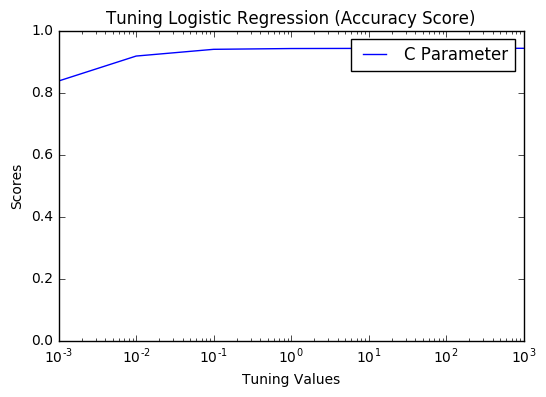

In [16]:
plot_tuning_results(cs, tr, False, None, True, 'C Parameter', None, 'Tuning Logistic Regression (Accuracy Score)')

In [17]:
trf = np.empty((len(cs), ))
for i, c in enumerate(cs):
    trf[i] = KFold_Score(5, fi.as_matrix(),
                        np.array(y),
                        linear_model.LogisticRegression(C=c),
                        metric_func=metrics.f1_score)

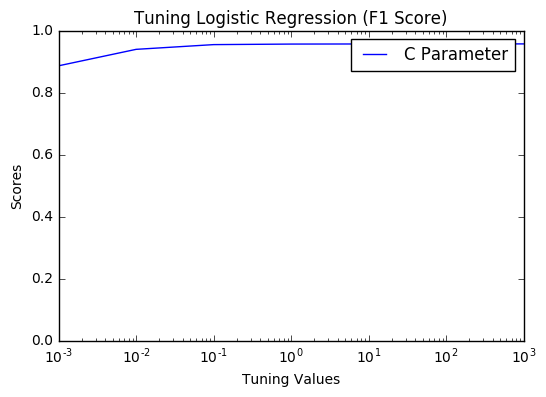

In [18]:
plot_tuning_results(cs, trf, False, None, True, 'C Parameter', None, 'Tuning Logistic Regression (F1 Score)')

In [19]:
trp = np.empty((len(cs), ))
for i, c in enumerate(cs):
    trp[i] = KFold_Score(5, fi.as_matrix(),
                        np.array(y),
                        linear_model.LogisticRegression(C=c),
                        metric_func=metrics.precision_score)

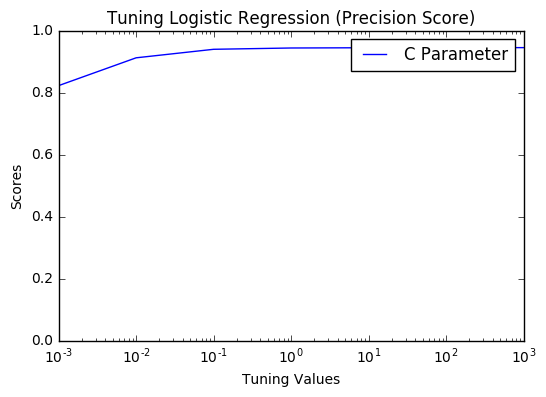

In [20]:
plot_tuning_results(cs, trp, False, None, True, 'C Parameter', None, 'Tuning Logistic Regression (Precision Score)')

### 2. Logistic Regression with Weather - No Yelp!, 2 Classes

#### Weather Data

In [21]:
weather_df = pd.read_csv('datasets/weather.csv')

In [22]:
weather_df.head()

,STATION,ELEVATION,LATITUDE,LONGITUDE,DATE,TAVG,TMAX,TMIN
0,GHCND:USC00111550,180.4,41.86611,-87.61528,20100101,-9999,21,10
1,GHCND:USC00111550,180.4,41.86611,-87.61528,20100102,-9999,16,7
2,GHCND:USC00111550,180.4,41.86611,-87.61528,20100103,-9999,24,6
3,GHCND:USC00111550,180.4,41.86611,-87.61528,20100104,-9999,21,13
4,GHCND:USC00111550,180.4,41.86611,-87.61528,20100105,-9999,27,19


In [23]:
def datetime_helper(str_):
    return pd.to_datetime(str_, format='%Y%m%d')

# reindex to dates
weather_df.index = weather_df['DATE'].apply(lambda x: datetime_helper(x)).rename('DATEINDEX')
weather_df = weather_df.drop(['DATE'], axis=1)

In [24]:
weather_df.head()

,STATION,ELEVATION,LATITUDE,LONGITUDE,TAVG,TMAX,TMIN
DATEINDEX,,,,,,,
2010-01-01,GHCND:USC00111550,180.4,41.86611,-87.61528,-9999,21,10
2010-01-02,GHCND:USC00111550,180.4,41.86611,-87.61528,-9999,16,7
2010-01-03,GHCND:USC00111550,180.4,41.86611,-87.61528,-9999,24,6
2010-01-04,GHCND:USC00111550,180.4,41.86611,-87.61528,-9999,21,13
2010-01-05,GHCND:USC00111550,180.4,41.86611,-87.61528,-9999,27,19


We will now plot daily fluctuations in the weather:

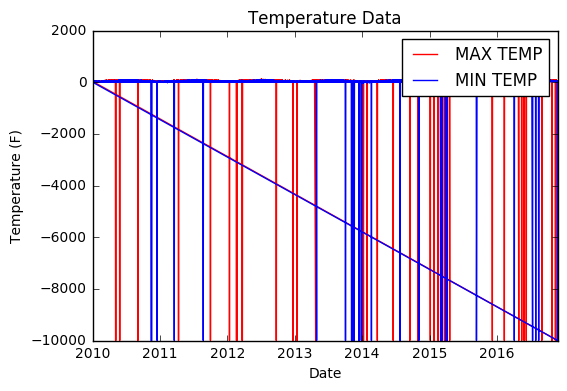

In [25]:
plt.plot(weather_df.index, weather_df['TMAX'], label='MAX TEMP', color='red')
plt.plot(weather_df.index, weather_df['TMIN'], label='MIN TEMP', color='blue')
plt.title('Temperature Data')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Temperature (F)');

In [26]:
weather_df['TMAX'][weather_df['TMAX'] == -9999].head()

DATEINDEX
2011-04-12   -9999
2012-03-21   -9999
2012-03-22   -9999
2012-03-23   -9999
2014-06-18   -9999
Name: TMAX, dtype: int64

Missing values are an issue: -> sklearn imputer

In [27]:
temp_imputer = preprocessing.Imputer(missing_values=-9999, axis=0, strategy='median')
fixed_temps = temp_imputer.fit_transform(weather_df[['TMAX', 'TMIN']])

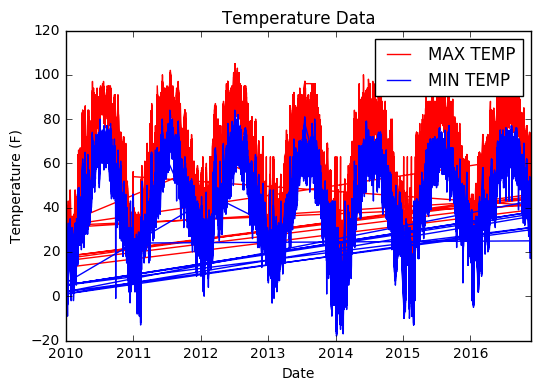

In [28]:
plt.plot(weather_df.index, fixed_temps[:, 0], label='MAX TEMP', color='red')
plt.plot(weather_df.index, fixed_temps[:, 1], label='MIN TEMP', color='blue')
plt.title('Temperature Data')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Temperature (F)');

Different stations are confounding results

In [29]:
weather_df.groupby('STATION').count()

,ELEVATION,LATITUDE,LONGITUDE,TAVG,TMAX,TMIN
STATION,,,,,,
GHCND:USC00111497,2515,2515,2515,2515,2515,2515
GHCND:USC00111550,2491,2491,2491,2491,2491,2491
GHCND:USC00111577,2519,2519,2519,2519,2519,2519
GHCND:USC00115097,2453,2453,2453,2453,2453,2453
GHCND:USC00115110,1424,1424,1424,1424,1424,1424
GHCND:USC00116616,2510,2510,2510,2510,2510,2510
GHCND:USC00117457,2517,2517,2517,2517,2517,2517
GHCND:USC00118324,689,689,689,689,689,689
GHCND:USW00004838,2513,2513,2513,2513,2513,2513


In [30]:
weather_df = weather_df[weather_df['STATION']=='GHCND:USW00094846']

In [31]:
temp_imputer = preprocessing.Imputer(missing_values=-9999, axis=0, strategy='median')
fixed_temps = temp_imputer.fit_transform(weather_df[['TMAX', 'TMIN']])

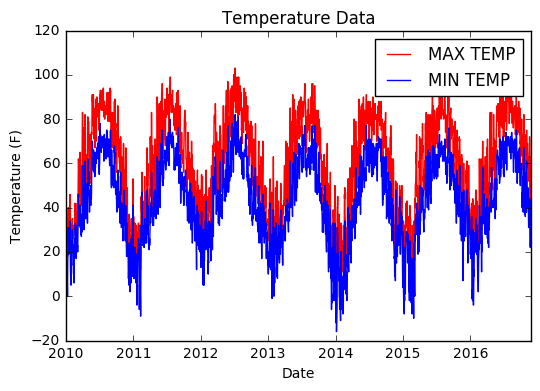

In [32]:
plt.plot(weather_df.index, fixed_temps[:, 0], label='MAX TEMP', color='red')
plt.plot(weather_df.index, fixed_temps[:, 1], label='MIN TEMP', color='blue')
plt.title('Temperature Data')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Temperature (F)');

Now that we have a clean dataset of the weather, we will be able to fit a model that uses the date as a proxy for the weather conditions. This is particularly useful as it allows us to forecast for **future** data as opposed to just data for dates we already have and temperatures already recorded. Let's create a model for this now. 

In [33]:
from statsmodels.api import tsa

def plot_autocorrelation_graphs(ts, nlags):
    
    plt.rcParams['figure.figsize'] = (10, 6)
    
    fig, (axacf, axpacf) = plt.subplots(2, 1, sharex=True, sharey=False)
    
    # acf
    axacf.bar(xrange(nlags+1), tsa.acf(ts, nlags=nlags), color='blue')
    axacf.set_title('Autocorrelation Function')
    axacf.set_ylabel('ACF')
    axacf.set_xlabel('Lags')
    
    # pacf
    axpacf.bar(xrange(nlags+1), tsa.pacf(ts, nlags=nlags), color='blue')
    axpacf.set_title('Partial Autocorrelation Function')
    axpacf.set_ylabel('PACF')
    axpacf.set_xlabel('Lags')
    
    
    plt.tight_layout();

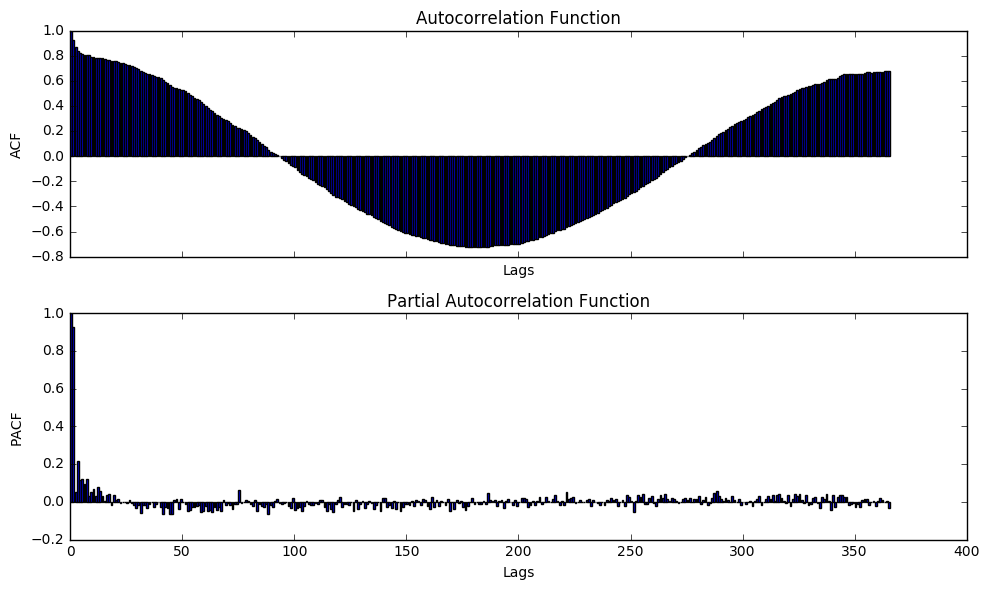

In [34]:
plot_autocorrelation_graphs(fixed_temps[:, 0], 365)

As we can see above, there is a hige amount of autocorrelation in these time series. We will need to choose the best ARMA model possible. I am hesitatnt however to include an AR 365 component into the model as this requires a huge number of parameters to be fit. To deal with this, I will resample to monthly data.

In [35]:
weather_df = pd.DataFrame(data=fixed_temps, index=weather_df.index, columns=['MAX', 'MIN'])

In [36]:
weather_df_monthly = weather_df.resample('M').mean()

MAX


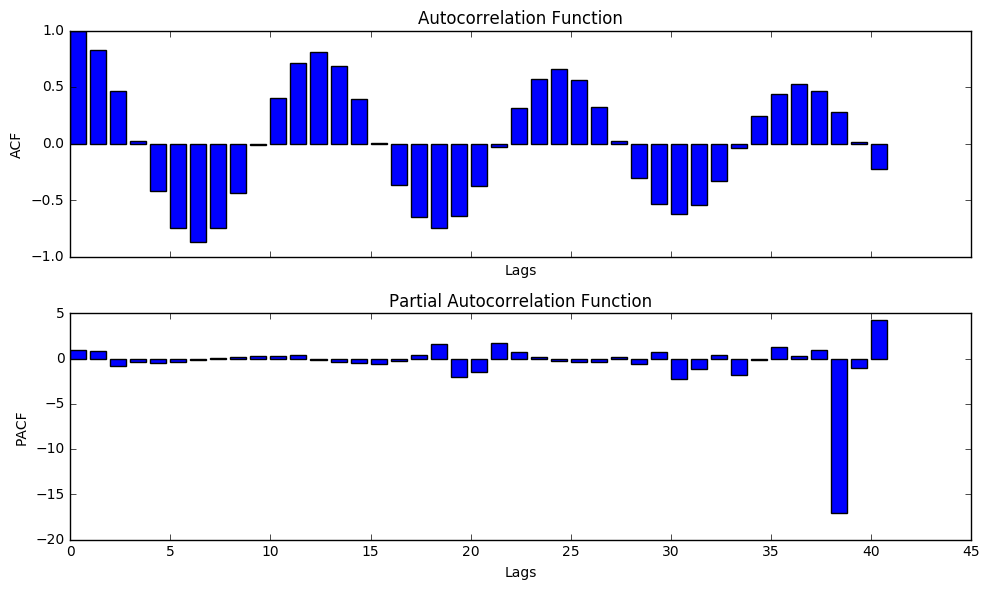

In [37]:
plot_autocorrelation_graphs(weather_df_monthly.iloc[:, 0], 40)
print 'MAX'

MIN


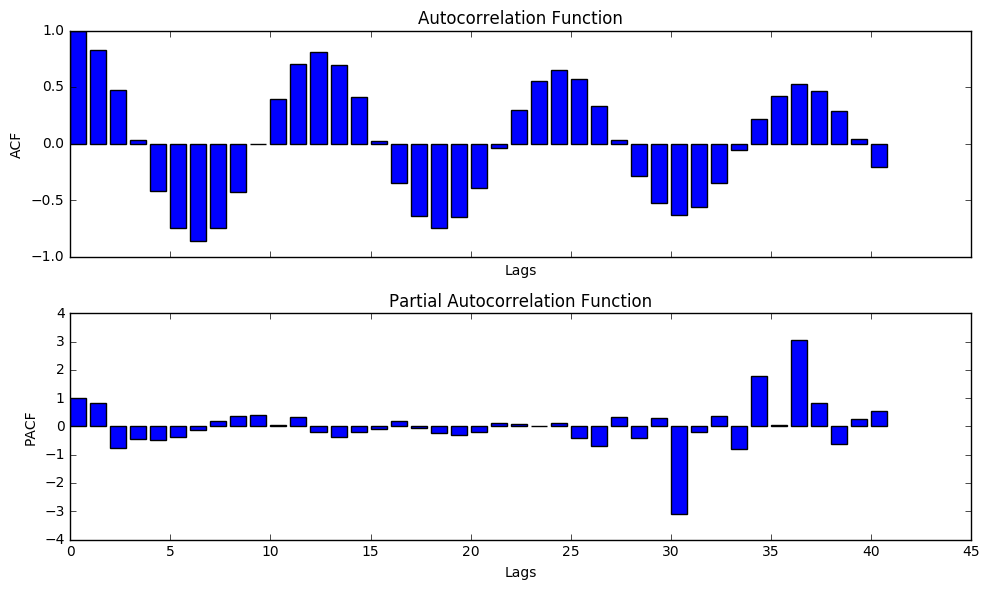

In [38]:
plot_autocorrelation_graphs(weather_df_monthly.iloc[:, 1], 40)
print 'MIN'

In [39]:
ARMA_model_max = tsa.ARMA(weather_df_monthly.iloc[:, 0], (12,0), freq='M').fit()
ARMA_model_min = tsa.ARMA(weather_df_monthly.iloc[:, 1], (12,0), freq='M').fit()

//anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [40]:
fitted_arma_max = ARMA_model_max.fittedvalues
fitted_arma_min = ARMA_model_min.fittedvalues

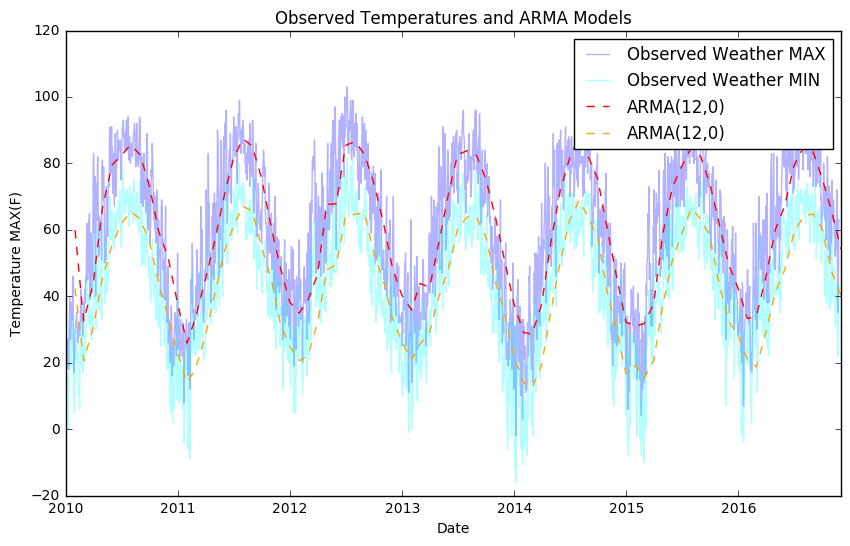

In [41]:
plt.plot(weather_df.index, fixed_temps[:, 0], color='blue', alpha=0.3, label='Observed Weather MAX')
plt.plot(weather_df.index, fixed_temps[:, 1], color='cyan', alpha=0.3, label='Observed Weather MIN')
plt.plot(fitted_arma_max, color='red', label='ARMA(12,0)', ls='--')
plt.plot(fitted_arma_min, color='orange', label='ARMA(12,0)', ls='--')
plt.title('Observed Temperatures and ARMA Models')
plt.ylabel('Temperature MAX(F)')
plt.xlabel('Date')
plt.legend();

In [42]:
def date_to_temps(date, model_max, model_min, params):
    """
    Function that takes in a date and 
    models for maximum and minimum tempteratures and
    produces a result based on this. Params in tuple (p,q) form
    """
    date_end = model_max.data.dates[-1]
    
    # if in values already
    if date <= date_end:
        date = date + pd.offsets.MonthEnd(0)
        max_series = pd.Series(data=model_max.data.endog, index=model_max.data.dates)
        min_series = pd.Series(data=model_min.data.endog, index=model_min.data.dates)
        predmax = max_series[date]
        predmin = min_series[date]
    
    # if must be forecast
    else:
        months = (date.year - date_end.year)*12 + date.month - date_end.month
        predmax = model_max.forecast(months)[0][-1]
        predmin = model_min.forecast(months)[0][-1]
        
    return predmax, predmin

In [43]:
date_to_temps(pd.to_datetime('2018-01-01'), ARMA_model_max, ARMA_model_min, (12,0))

(38.640105375565795, 21.835013003622251)

Now that we have a good way of accessing and forecasting time, we will now add this time element to the logistic regression. We will add this element to clean and split.

In [47]:
def clean_and_split(df, temp_mdl_max, temp_mdl_min, mdl_params):
    """
    Function to clean raw food inspection data and
    split this into predictor and label parts
    """
    df = df.drop(['DBA Name', 'AKA Name', 'Address', 'City', 'State'], 1)
    df = df.drop('Location', 1)
    
    """
    Here we deal with our new date element
    """
    temps = [date_to_temps(pd.to_datetime(x), temp_mdl_max, temp_mdl_min, mdl_params) for x in df['Inspection Date']]
    time_df = pd.DataFrame(temps, columns=['TMAX', 'TMIN'])
    df = pd.concat([df, time_df], axis=1)                         
    df = df.drop('Inspection Date', 1) # NB will most likely be included in the final model
    
    # clean inspection types
    df['Inspection Type'] = inp_type_helper(df, df.loc[:, 'Inspection Type'])
    
    # clean facility types
    df['Facility Type'] = fac_type_helper(df, df.loc[:, 'Facility Type'])
    
    # clean risk types
    df['Risk'] = risk_helper(df['Risk'])
    
    # clean violations and add number of violations
    no_viols, viols = viols_helper(df)
    df['# of Violations'] = no_viols
    df['Violations'] = viols
    
    # split columns into dummies
    viols_dummies_df = pd.get_dummies(pd.Series(df['Violations']).apply(pd.Series).stack()).sum(level=0)
    zip_dummies_df = pd.get_dummies(df['Zip'])
    inp_dummies_df = pd.get_dummies(df['Inspection Type'])
    fac_dummies_df = pd.get_dummies(df['Facility Type'])
    
    # drop columns that are now dummies
    df = df.drop(['Violations', 'Zip', 'Inspection Type', 'Facility Type'], 1)
    
    # add dummy columns
    df = pd.concat([df, viols_dummies_df, zip_dummies_df, inp_dummies_df, fac_dummies_df], axis=1)
    
    # drop last column
    df = df.drop('License #', 1)
    
    # drop nans, which will cause models to fail
    df = df.dropna(axis=0)
    
    # split off results and predictors and clean into Pass/Fail. Possible multiclass in future
    y = results_helper(df.loc[:, 'Results'])
    df = df.drop('Results', 1)
    
    return (df, y)

In [48]:
fi, y = clean_and_split(FI, ARMA_model_max, ARMA_model_min, (12, 0))

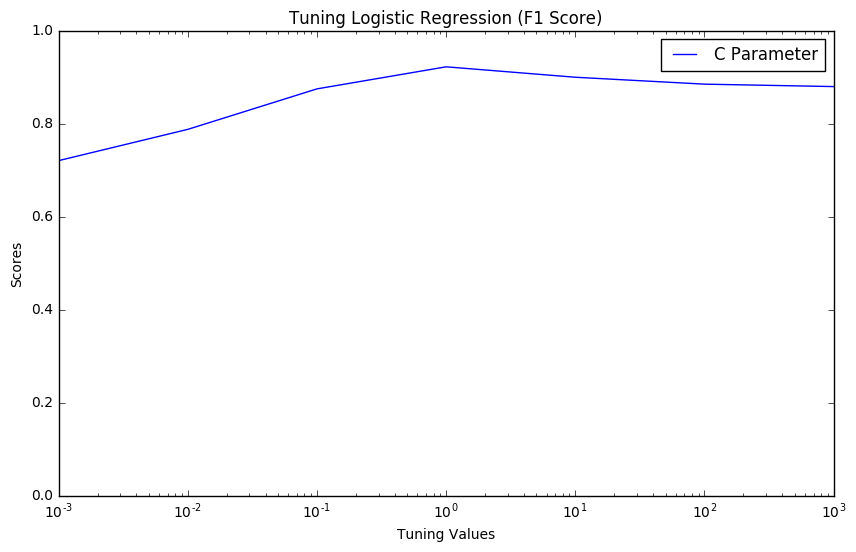

In [49]:
tr = np.empty((len(cs), ))
for i, c in enumerate(cs):
    tr[i] = KFold_Score(5, fi.as_matrix(),
                        np.array(y),
                        linear_model.LogisticRegression(C=c),
                        metric_func=metrics.accuracy_score)
plot_tuning_results(cs, tr, False, None, True, 'C Parameter', None, 'Tuning Logistic Regression (F1 Score)')

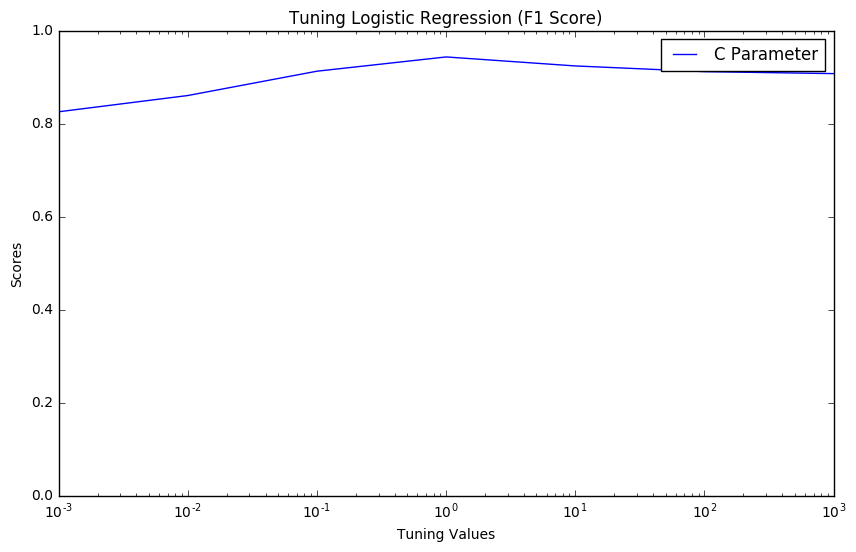

In [50]:
trf = np.empty((len(cs), ))
for i, c in enumerate(cs):
    trf[i] = KFold_Score(5, fi.as_matrix(),
                        np.array(y),
                        linear_model.LogisticRegression(C=c),
                        metric_func=metrics.f1_score)
plot_tuning_results(cs, trf, False, None, True, 'C Parameter', None, 'Tuning Logistic Regression (F1 Score)')

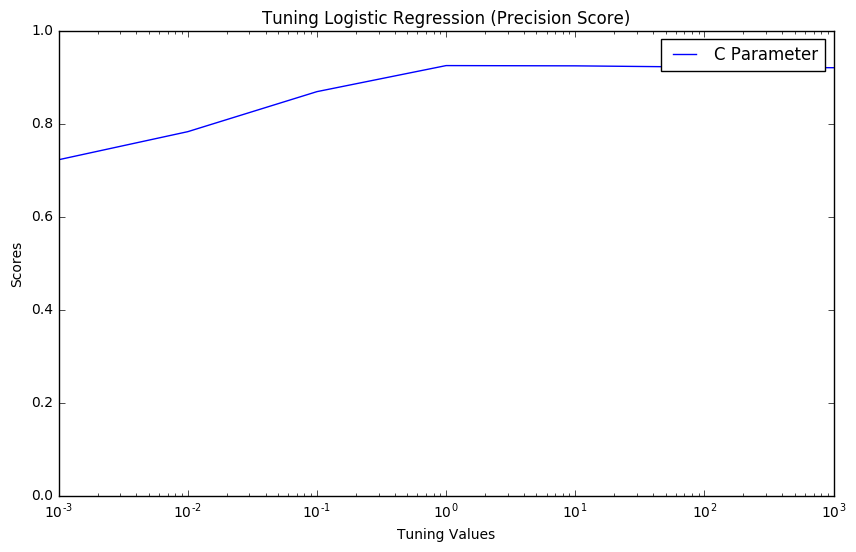

In [51]:
trp = np.empty((len(cs), ))
for i, c in enumerate(cs):
    trp[i] = KFold_Score(5, fi.as_matrix(),
                        np.array(y),
                        linear_model.LogisticRegression(C=c),
                        metric_func=metrics.precision_score)
plot_tuning_results(cs, trp, False, None, True, 'C Parameter', None, 'Tuning Logistic Regression (Precision Score)')

In [52]:
# baseline
KFold_Score(10, fi.as_matrix(), np.array(y), linear_model.LogisticRegression(C=1))

0.92130317123585725

In [53]:
linmod = linear_model.LogisticRegression(C=1).fit(fi.as_matrix(), np.array(y))
importance_series = pd.Series(data=linmod.coef_[0], index=fi.columns).sort_values(ascending=False)

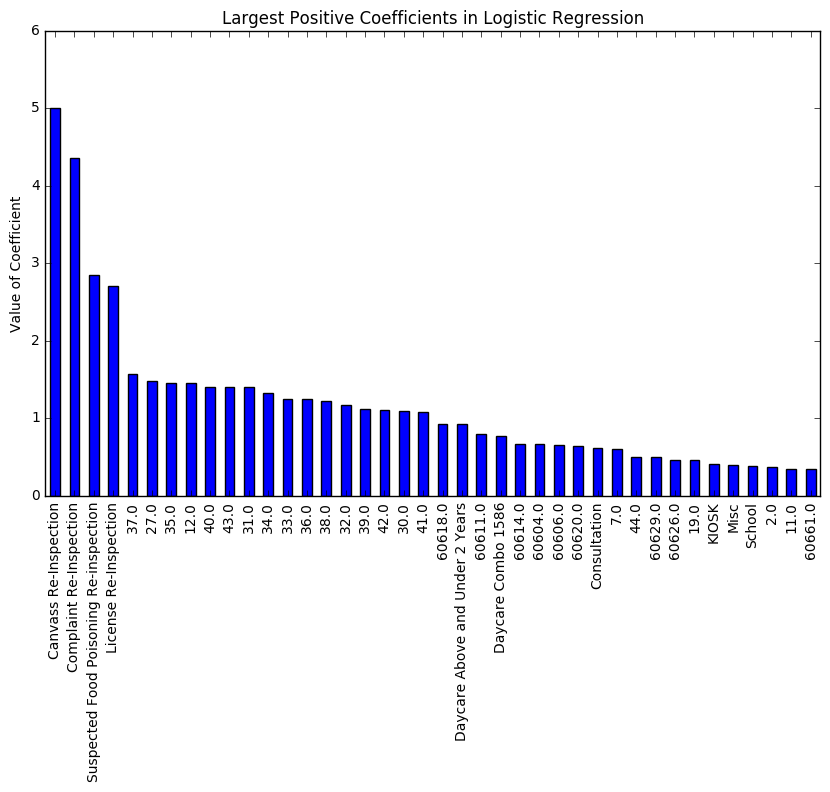

In [54]:
importance_series.head(40).plot(kind='bar')
plt.title('Largest Positive Coefficients in Logistic Regression')
plt.ylabel('Value of Coefficient');

Type of inspection, type of violation found, zip code all drivers of model.

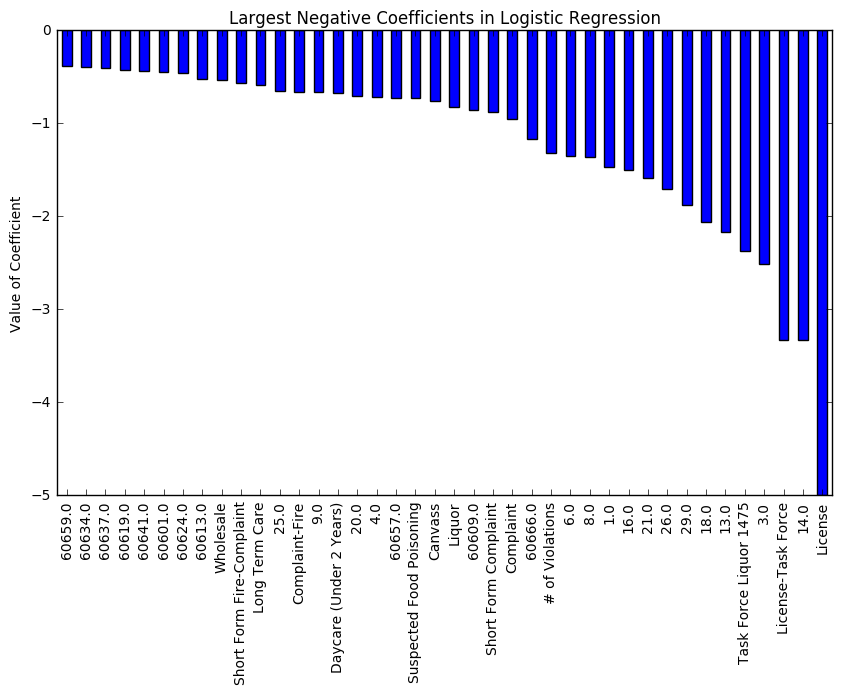

In [55]:
importance_series.tail(40).plot(kind='bar')
plt.title('Largest Negative Coefficients in Logistic Regression')
plt.ylabel('Value of Coefficient');

In [56]:
importance_series[['TMAX', 'TMIN']]

TMAX    0.092627
TMIN   -0.090234
dtype: float64

#### Nearby Violations

Another predictor: the number of violations within a 1km radius of a food establishment.

In [57]:
import geopy

In [58]:
from geopy import distance

In [59]:
dist = distance.distance(FI['Location'].iloc[0], FI['Location'].iloc[1])

In [152]:
def violations_in_radius(locations, nviolations, radius):
    viols_in_dist = np.zeros((len(locations,)))
    for i, loc1 in enumerate(locations):
        for j, loc2 in enumerate(locations):
            if (distance.great_circle(loc1, loc2).meters < radius) and (distance.great_circle(loc1, loc2).meters > 10):
                viols_in_dist[i] = viols_in_dist[i] + nviolations.iloc[j]
    return viols_in_dist

# ------ TOOOO LOONG------

Add to clean and split.

In [143]:
def gridsplit(df, n_squares):
    lats = np.linspace(df['Latitude'].min(), df['Latitude'].max(), n_squares)
    longs = np.linspace(df['Longitude'].min(), df['Longitude'].max(), n_squares)
    results = np.zeros((n_squares, n_squares))
    for i, lat in enumerate(lats):
        for j, long_ in enumerate(longs):
            for k in df.index:
                if (df.loc[k, 'Latitude'] > lats[i-1]) & (df.loc[k, 'Latitude'] < lat) & (df.loc[k, 'Longitude'] > longs[i-1]) & (df.loc[k, 'Longitude'] < long_):
                    results[i, j] = results[i, j] + df.loc[k,'# of Violations']
    return results

In [149]:
grid_of_violations = gridsplit(fi[['Latitude', 'Longitude', '# of Violations']], 20)

In [150]:
grid_of_violations

array([[   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    8.,   24.,   43.,   43.,
          43.,   43.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,   10.,   10.,
          10.,   10.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    5.,    5.,    8.,    8.,    8.,   10.,
          13.,   13.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    3.,   20.,   20.,   21.,   34.,   43.,   52.,   62.,
          68.,   68.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           3.,    3.,    3.,   48.,   51.,   59.,   87.,  111.,  129.,
         140.,  140.],
       [  

In [151]:
import pickle
pickle.dump(grid_of_violations, open( "grid_of_violations.p", "wb" ))

In [157]:
# pickle.load(open( "grid_of_violations.p", "wb" ))
grid_ = pd.DataFrame(data=grid_of_violations,
                     index=np.linspace(FI['Latitude'].min(), FI['Latitude'].max(), 20),
                     columns=np.linspace(FI['Longitude'].min(), FI['Longitude'].max(), 20)
)

In [159]:
grid_

,-87.9144284393,-87.8939371602,-87.873445881,-87.8529546019,-87.8324633228,-87.8119720437,-87.7914807645,-87.7709894854,-87.7504982063,-87.7300069272,-87.7095156481,-87.6890243689,-87.6685330898,-87.6480418107,-87.6275505316,-87.6070592525,-87.5865679733,-87.5660766942,-87.5455854151,-87.525094136
41.644670,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41.664480,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,24.0,43.0,43.0,43.0,43.0
41.684291,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,10.0,10.0,10.0
41.704101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,8.0,8.0,8.0,10.0,13.0,13.0
41.723911,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,20.0,20.0,21.0,34.0,43.0,52.0,62.0,68.0,68.0
41.743721,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,48.0,51.0,59.0,87.0,111.0,129.0,140.0,140.0
41.763531,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,20.0,41.0,59.0,59.0,71.0,71.0,96.0,98.0,120.0,121.0,127.0,127.0
41.783342,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,22.0,22.0,40.0,40.0,46.0,57.0,76.0,91.0,135.0,166.0,166.0,166.0
41.803152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,41.0,41.0,54.0,64.0,66.0,95.0,96.0,96.0,96.0
41.822962,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.0,55.0,97.0,142.0,142.0,142.0,142.0,142.0


In [210]:
from ast import literal_eval as make_tuple

def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

def get_viols_from_coords(grid, val):
    if pd.isnull(val):
        return 0.
    else:
        long_, lat = make_tuple(val)
        index_ = grid.index
        columns_ = grid.columns
        nearest_index = find_nearest(index_, long_)
        nearest_column= find_nearest(columns_, lat)
        return grid.loc[nearest_index, nearest_column]

In [214]:
def clean_and_split(df, temp_mdl_max, temp_mdl_min, mdl_params, grid_):
    """
    Function to clean raw food inspection data and
    split this into predictor and label parts
    """
    df = df.drop(['DBA Name', 'AKA Name', 'Address', 'City', 'State'], 1)
    
    temps = [date_to_temps(pd.to_datetime(x), temp_mdl_max, temp_mdl_min, mdl_params) for x in df['Inspection Date']]
    time_df = pd.DataFrame(temps, columns=['TMAX', 'TMIN'], index=df.index)
    df = pd.concat([df, time_df], axis=1)
    df = df.drop('Inspection Date', 1)
    
    # clean inspection types
    df['Inspection Type'] = inp_type_helper(df, df.loc[:, 'Inspection Type'])
    
    # clean facility types
    df['Facility Type'] = fac_type_helper(df, df.loc[:, 'Facility Type'])
    
    # clean risk types
    df['Risk'] = risk_helper(df['Risk'])
    
    # clean violations and add number of violations
    no_viols, viols = viols_helper(df)
    df['# of Violations'] = no_viols
    df['Violations'] = viols
    
    df['Grid Violations'] = df['Location'].apply(lambda x: get_viols_from_coords(grid_, x))
    df = df.drop('Location', 1)
    
    # split columns into dummies
    viols_dummies_df = pd.get_dummies(pd.Series(df['Violations']).apply(pd.Series).stack()).sum(level=0)
    zip_dummies_df = pd.get_dummies(df['Zip'])
    inp_dummies_df = pd.get_dummies(df['Inspection Type'])
    fac_dummies_df = pd.get_dummies(df['Facility Type'])
    
    # drop columns that are now dummies
    df = df.drop(['Violations', 'Zip', 'Inspection Type', 'Facility Type'], 1)
    
    # add dummy columns
    df = pd.concat([df, viols_dummies_df, zip_dummies_df, inp_dummies_df, fac_dummies_df], axis=1)
    
    # drop last column
    df = df.drop('License #', 1)
    
    # drop nans, which will cause models to fail
    df = df.dropna(axis=0)
    
    # split off results and predictors and clean into Pass/Fail. Possible multiclass in future
    y = results_helper(df.loc[:, 'Results'])
    df = df.drop('Results', 1)
    
    return (df, y)

In [217]:
fi, y = clean_and_split(FI, ARMA_model_max, ARMA_model_min, (12, 0), grid_)

In [219]:
KFold_Score(5,
            fi.as_matrix(),
            np.array(y),
            linear_model.LogisticRegression(C=1),
            metric_func=metrics.accuracy_score
)

0.94330684267898557

In [224]:
import geopandas